# We Do Parkinson Disease prediction using LSTM Neural Network

It's time to discover my project

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "ankle_acc_x_",
    "ankle_acc_y_",
    "ankle_acc_z_",
    "upperleg_acc_x_",
    "upperleg_acc_y_",
    "upperleg_acc_z_",
    "trunk_acc_x_",
    "trunk_acc_y_",
    "trunk_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "NON-FREEZING",
    "FREEZING"
] 

## Preparing Dataset

In [ ]:
np.int16

## Old Data Loading code

In [ ]:
TRAIN = 'D:/Master\'s Project/dataset_fog_release/dataset/Train/'
TEST = 'D:/Master\'s Project/dataset_fog_release/dataset/Test/'
BATCH_SIZE = 128
# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    batch_size = 0
    batch_signals = []
    for root, dirs, filenames in os.walk(X_signals_paths):
        for fffDir in filenames:
            file = open(X_signals_paths + fffDir, 'r')
            for row in file:
                if int(row.strip().split(' ')[1:][9]) != 0:
                    batch_size += 1
                    if batch_size % BATCH_SIZE == 0:
                        batch_signals += [row.strip().split(' ')[1:]]
                        batch_size = 0
                        X_signals += [batch_signals]
                        batch_signals = []
                    else:
                        #print(batch_size)
                        batch_signals += [row.strip().split(' ')[1:]]
                
            #print(batch_size)
            file.close()
            
    return np.transpose(np.array(X_signals,dtype=np.int16),(1, 2, 0))    

X_train = load_X(TRAIN)
X_test = load_X(TEST)

## New Data Loading Code

#### BATCH_SIZE here is the Batching input data

In [3]:
TRAIN = 'D:/Master\'s Project/dataset_fog_release/dataset/Train/'
TEST = 'D:/Master\'s Project/dataset_fog_release/dataset/Test/'
BATCH_SIZE = 30
# creating batches in other way
def load_New_X(X_signals_paths):
    X_signals = []
    batch_size = 0
    for root, dirs, filenames in os.walk(X_signals_paths):
        for fffDir in filenames:
            file = open(X_signals_paths + fffDir, 'r')
            for row in file:
                batch_signals = []
                if int(row.strip().split(' ')[1:][9]) != 0:
                    batch_signals += [row.strip().split(' ')[1:]]
                    X_signals += batch_signals 
            #print(batch_size)
            file.close()
            
    return X_signals

X_train_batching = np.array(load_New_X(TRAIN),dtype=np.int16)
X_test_batching = np.array(load_New_X(TEST),dtype=np.int16)

## Checking out the type of data

### This batch size is used to predict ahead value of how much amount

In [4]:
print(type(X_train_batching))
print(type(X_test_batching))
batch_size = 250

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Making the data to numpy array

In [5]:
X_train_batching = np.array(X_train_batching)
X_test_batching = np.array(X_test_batching)

### Getting only the labels from the dataset

In [6]:
y_train_new1 = []
y_test_new1 = []
y_train_new = np.array([X_train_batching[:len(X_train_batching),9]])
y_test_new = np.array([X_test_batching[:len(X_test_batching),9]])

### Reshaping the labels 

In [7]:
y_train_new = y_train_new.reshape(len(y_train_new[0]),1)
y_test_new = y_test_new.reshape(len(y_test_new[0]),1)
print(y_train_new.shape)
print(y_test_new.shape)

(319688, 1)
(152326, 1)


In [8]:
y_train_new

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int16)

### Maintaing Label Consistency

In [9]:
for i in range(0,len(y_train_new)-BATCH_SIZE):
    if (i + (batch_size*2)) < len(y_train_new):
        y_train_new1 += [y_train_new[i + (batch_size*2)][0]-1]
    else:
        y_train_new1 += [0]
        
for i in range(0,len(y_test_new)-BATCH_SIZE):
    if (i + (batch_size*2)) < len(y_test_new):
        y_test_new1 += [y_test_new[i + (batch_size*2)][0]-1]
    else:
        y_test_new1 += [0]

y_train_new = y_train_new1
y_test_new = y_test_new1

In [10]:
y_train_new = np.array(y_train_new)
print(y_train_new.shape)

(319658,)


In [ ]:
#def reshapeLabels(y_train_new):
#    labels = []
#    for i in range(0, len(y_train_new)):
#        labels += [str(y_train_new[i][0])]
#    return labels    

#### Unused code

In [ ]:
y_train_new = reshapeLabels(y_train_new)#[int(y) for y in x[0][0] for x in y_train_new[0]]
y_test_new = reshapeLabels(y_test_new)#y_test_new = y_test_new

### Converting labels to numpy after refactoring

In [11]:
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
print(np.unique(y_train_new))
print(np.unique(y_test_new))

[0 1]
[0 1]


In [12]:
#y_train_new = np.array([X_train_batching[:len(X_train_batching)-BATCH_SIZE,9]])
#y_test_new = np.array([X_test_batching[:len(X_test_batching)-BATCH_SIZE,9]])
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
print(y_train_new.shape)
print(y_test_new.shape)

(319658,)
(152296,)


In [13]:
y_train_new[0]

0

## Code to create Batch sized chunk of each data instance

In [14]:
# Now batching the data as with batch size 128
def createBatching(X_train,batch_size):
    transformData = []
    for i in range(0,(len(X_train)-batch_size)):
        batch_data = X_train[i:i+batch_size,0:9]
        transformData += [batch_data]
    return np.array(transformData,dtype=np.int16)
    
X_train_batching = createBatching(X_train_batching, BATCH_SIZE)

In [15]:
X_train_batching.shape

(319658, 30, 9)

### Reshaping the training batched dataset

In [16]:
X_train_batching.shape
len(X_train_batching[0][0])
X_train_batching = np.reshape(X_train_batching,(len(X_train_batching[0]),len(X_train_batching[0][0]),len(X_train_batching)))

### Reshaping the test batched dataset

In [17]:
X_train_batching.shape
X_test_batching = createBatching(X_test_batching, BATCH_SIZE)
X_test_batching = np.reshape(X_test_batching,(len(X_test_batching[0]),len(X_test_batching[0][0]),len(X_test_batching)))

In [ ]:
len(y_train_new)

In [18]:
### Transforming the labels now
y_train_new = np.transpose(np.array(y_train_new))
y_train_new = np.reshape(y_train_new,(len(y_train_new),1))
y_test_new = np.transpose(np.array(y_test_new))
y_test_new.shape
y_test_new = np.reshape(y_test_new,(len(y_test_new),1))

## Ytrain X_train training set and data

In [19]:
y_train = y_train_new
y_test = y_test_new
X_train = np.transpose(X_train_batching,(2, 0, 1))
X_test = np.transpose(X_test_batching,(2, 0, 1))
y_train.shape

(319658, 1)

In [ ]:
X_test.shape

#### Old code

In [ ]:
y_train = np.transpose(X_train[:,9,:],(1, 0))
y_test = np.transpose(X_test[:,9,:],(1, 0))
X_train = np.transpose(X_train[:,:-1,:],(2, 0, 1))
X_test = np.transpose(X_test[:,:-1,:],(2, 0, 1))
y_train.shape

## Additional Parameters:
#### Here are some core parameter definitions for the training. 
##### The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [20]:
# Input Data 

training_data_count = len(X_train)  # 5377 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = BATCH_SIZE # Hidden layer num of features
n_classes = 2 # Total classes (should go up, or should go down)


# Training 
learning_rate = 0.00009      #5
lambda_loss_amount = 0.0015
training_iters = training_data_count * 1  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(152296, 30, 9) (152296, 1) 359.08190234805903 511.3782588587977
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [21]:
def LSTM_RNN(_X, _weights, _biases):
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    #print(batch_s)
    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    #print(len(y_))
    y_ = y_.reshape(len(y_))
    n_values = 2 #int(np.max(y_)) + 1
    y_out = np.eye(n_values)[np.array(y_, dtype=np.int32)]
    #print(y_out)
    return y_out # Returns FLOATS

In [22]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    #'hidden': tf.Variable(tf.random_normal([n_hidden, n_hidden/2])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    #'hidden': tf.Variable(tf.random_normal([n_hidden/2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
_X = tf.transpose(x, [1, 0, 2])
print(_X)
_X = tf.reshape(_X, [-1, n_input]) 
print(_X)
print(weights['hidden'])

Tensor("transpose:0", shape=(30, ?, 9), dtype=float32)
Tensor("Reshape:0", shape=(?, 9), dtype=float32)
<tf.Variable 'Variable:0' shape=(9, 30) dtype=float32_ref>


## Let's get serious and build the neural network:

In [23]:
pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [24]:
np.unique(y_train)

array([0, 1])

# Old Transformed Counter

In [ ]:
from collections import Counter
y_train_transformed = []
for i in range(0,len(y_train)):
    y_counter = Counter(np.array(y_train[i]))
    y_train_transformed += [[y_counter.most_common(1)[0][0]-1]]
y_train = np.array(y_train_transformed)

y_test_transformed = []
for i in range(0,len(y_test)):
    y_counter = Counter(np.array(y_test[i]))
    y_test_transformed += [[y_counter.most_common(1)[0][0]-1]]

y_test = np.array(y_test_transformed)

print(y_train)
print(y_test.shape)

In [ ]:
print()

# Transformed new Counter

In [25]:
from collections import Counter
y_train_transformed = []
for i in range(0,len(y_train)):
    # y_counter = Counter(np.array(y_train[i]))
    y_train_transformed += [int(y_train[i])]
y_train = np.array(y_train_transformed)

y_test_transformed = []
for j in range(0,len(y_test)):
   # y_counter = Counter(np.array(y_test[i]))
    y_test_transformed += [int(y_test[j])]

y_test = np.array(y_test_transformed)

print(y_train.shape)
print(y_test.shape)

(319658,)
(152296,)


In [ ]:
#y_train = np.transpose(y_train)
y_train.shape

In [ ]:
np.sum(y_test)

In [ ]:
y_test = np.transpose(y_test)

## Hooray, now train the neural network:

In [26]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Training iter #1500:   Batch Loss = 1.333900, Accuracy = 0.30799999833106995
PERFORMANCE ON TEST SET: Batch Loss = 1.3569363355636597, Accuracy = 0.3048274517059326
Training iter #30000:   Batch Loss = 0.939761, Accuracy = 0.777999997138977
PERFORMANCE ON TEST SET: Batch Loss = 1.0482779741287231, Accuracy = 0.6396490931510925
Training iter #60000:   Batch Loss = 1.089259, Accuracy = 0.6673333048820496
PERFORMANCE ON TEST SET: Batch Loss = 0.8833789825439453, Accuracy = 0.8427601456642151
Training iter #90000:   Batch Loss = 0.658022, Accuracy = 0.9513333439826965
PERFORMANCE ON TEST SET: Batch Loss = 0.8313765525817871, Accuracy = 0.8719664216041565
Training iter #120000:   Batch Loss = 0.580754, Accuracy = 0.9900000095367432
PERFORMANCE ON TEST SET: Batch Loss = 0.8014042377471924, Accuracy = 0.879707932472229
Training iter #150000:   Batch Loss = 0.573323, Accuracy = 1.0
PERFORMANCE ON TEST SET: Batch Loss = 0.7931493520736694, Accuracy = 0.8803316950798035
Training iter #180000:   

D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


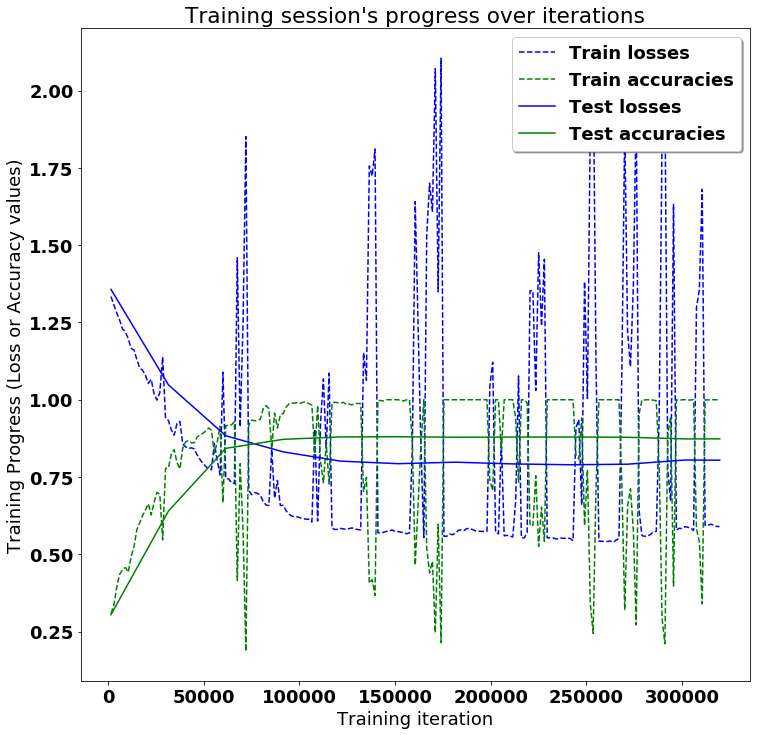

In [27]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 87.34241127967834%

Precision: 78.65976939344735%
Recall: 87.3424121447707%
f1_score: 82.3245228375302%

Confusion Matrix:
[[132895   1329]
 [ 17948    124]]

Confusion matrix (normalised to % of total test data):
[[8.72609918e+01 8.72642748e-01]
 [1.17849451e+01 8.14203919e-02]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


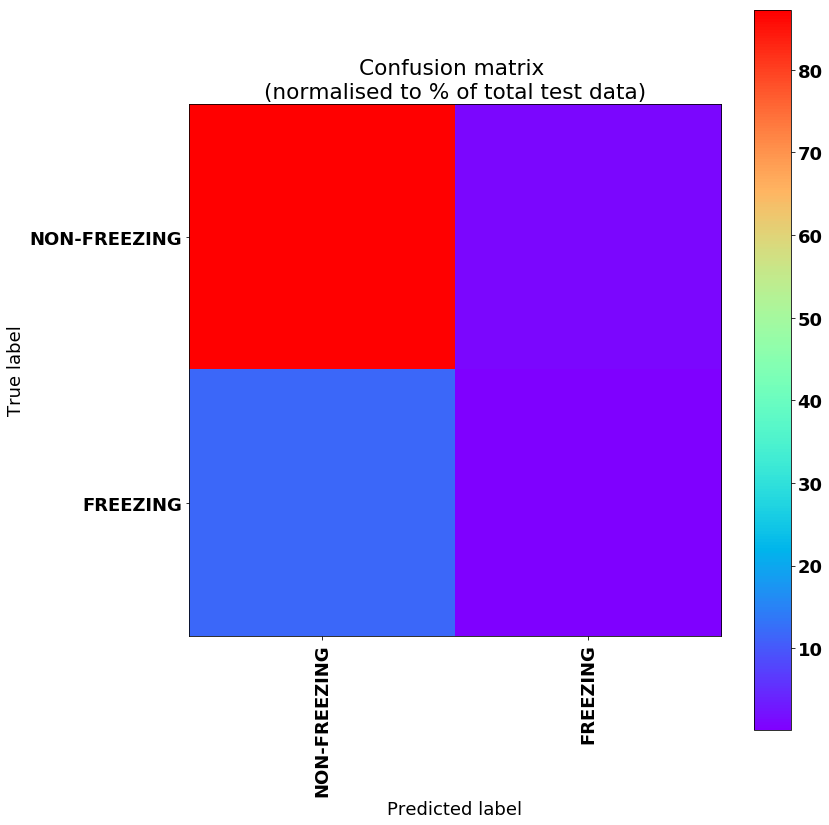

In [28]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
sess.close()

In [30]:
y_test.shape

(152296,)